<h1>Data Import and Path Setup</h2>

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from openTSNE import TSNE
import umap

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn import mixture

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

from time import time
import seaborn as sns


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
umap_seed = 143
tsne_seed = 42
max_jobs = -1    # If the RAM gets used up in your case, modify it to reduce RAM usage
num_comp = 2
num_clusters = 2

# Dataset extraction and analysis
path_expression = '../data/TCGA.BRCA.expression.txt'
path_metadata = '../data/TCGA.BRCA.metadata.txt'
path_mutation = '../data/TCGA.BRCA.mutations.txt'
path_sup = "../data/Supplementary Tables 1-4.csv"

df_exp = pd.read_csv(path_expression, delimiter='\t')  # \s+ handles multiple spaces
df_meta = pd.read_csv(path_metadata, delimiter='\t')
df_mut = pd.read_csv(path_mutation, delimiter=r'\t')
df_sup = pd.read_csv(path_sup, delimiter=',')
df_exp.head()


/tmp/ipykernel_620/606298354.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_mut = pd.read_csv(path_mutation, delimiter=r'\t')


,patient_id,sample_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,0.0000,16.3644,12.9316,52.1503,408.076,0.0,1187.010,0.0000,...,415.824,931.957,129.5920,1007.780,1658.500,258.4940,1208.370,3507.25,1894.930,1180.460
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,0.0000,9.2659,17.3790,69.7553,563.893,0.0,516.041,1.0875,...,1161.330,965.198,59.8151,448.613,1343.120,198.4770,603.589,5504.62,1318.650,406.743
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,0.9066,11.6228,9.2294,154.2970,1360.830,0.0,592.022,0.0000,...,305.422,2531.280,35.3581,533.998,768.812,331.8220,532.185,5458.75,942.883,509.519
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,0.0000,12.0894,11.0799,143.8640,865.536,0.0,552.751,0.4137,...,394.506,668.597,55.0269,437.733,863.881,175.4240,607.365,5691.35,781.134,700.869
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,0.0000,6.8468,14.4298,84.2128,766.383,0.0,260.851,0.4255,...,405.711,674.468,48.9362,424.255,1049.790,14.0426,775.745,4041.70,831.915,881.702


In [3]:
df_meta.head()


,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-3C-AAAU,BRCA,55.0,FEMALE,WHITE,Stage X,Infiltrating Lobular Carcinoma,[Not Available],WITH TUMOR,Alive,0.0,4047.0,0.0,4047.0,1.0,1808.0,1.0,1808.0,NaN
1,TCGA-3C-AALI,BRCA,50.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,4005.0,0.0,4005.0,0.0,4005.0,0.0,4005.0,NaN
2,TCGA-3C-AALJ,BRCA,62.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,1474.0,0.0,1474.0,0.0,1474.0,0.0,1474.0,NaN
3,TCGA-3C-AALK,BRCA,52.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IA,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,1448.0,0.0,1448.0,NaN,NaN,0.0,1448.0,NaN
4,TCGA-4H-AAAK,BRCA,50.0,FEMALE,WHITE,Stage IIIA,Infiltrating Lobular Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,348.0,0.0,348.0,0.0,348.0,0.0,348.0,NaN


In [4]:
df_mut.head()


,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,SIFT,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS
0,TCGA-3C-AAAU,WDR11,0,.,GRCh37,10,122668955,122668955,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,TATGAGATGTA,5
1,TCGA-3C-AAAU,GATA3,0,.,GRCh37,10,8115874,8115875,+,Frame_Shift_Ins,...,.,.,"Low_complexity_(Seg):seg,hmmpanther:PTHR10071:...",HIGH,insertion,PASS,NONE,INDELOCATOR*|VARSCANI*|PINDEL,CATCTCGCCCT,3
2,TCGA-3C-AAAU,MALAT1,0,.,GRCh37,11,65272906,65272908,+,RNA,...,.,.,.,MODIFIER,deletion,PASS,NONE,VARSCANI*|PINDEL,AATAATAAAGCCCA,2
3,TCGA-3C-AAAU,CD248,0,.,GRCh37,11,66082467,66082467,+,Missense_Mutation,...,tolerated(0.12),benign(0.001),"Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...",MODERATE,SNV,PASS,NONE,MUTECT|VARSCANS,GTGCTCGGCAA,2
4,TCGA-3C-AAAU,NPAS4,0,.,GRCh37,11,66193652,66193652,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,RADIA|MUTECT|MUSE|VARSCANS,ATCAAGAGACT,4


In [5]:
df_sup.head()

,Complete TCGA ID,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
0,TCGA-A2-A0T2,FEMALE,66.0,Negative,Negative,Negative,T3,T_Other,N3,Positive,...,Basal-like,0.0,-13.0,3.0,5.0,Basal,3.0,2.0,2.0,2.0
1,TCGA-A2-A04P,FEMALE,36.0,Negative,Negative,Negative,T2,T_Other,N3,Positive,...,Basal-like,0.0,-13.0,5.0,5.0,Basal,1.0,2.0,2.0,2.0
2,TCGA-A1-A0SK,FEMALE,54.0,Negative,Negative,Negative,T2,T_Other,N0,Negative,...,Basal-like,-6.0,-13.0,5.0,5.0,Basal,1.0,2.0,2.0,2.0
3,TCGA-A2-A0CM,FEMALE,40.0,Negative,Negative,Negative,T2,T_Other,N0,Negative,...,Basal-like,-12.0,-13.0,4.0,4.0,Basal,4.0,2.0,1.0,1.0
4,TCGA-AR-A1AR,FEMALE,50.0,Negative,Negative,Negative,T1,T1,N2,Positive,...,Basal-like,0.0,-13.0,5.0,5.0,NaN,1.0,NaN,NaN,NaN


In [6]:
df_exp.patient_id.isin(df_sup['Complete TCGA ID']).sum()

np.int64(917)

<h1>Data Preprocessing</h1>

<h2>Log2(X+1) Transform</h2>

In [7]:
df_logexp = pd.concat([df_exp.iloc[:,:2], np.log2(df_exp.iloc[:,2:]+1)], axis=1)
df_logexp.head()

,patient_id,sample_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,0.000000,4.118061,3.800289,5.732006,8.676225,0.0,10.214331,0.000000,...,8.703295,9.865667,7.028923,9.978396,10.696533,8.019557,10.240040,11.776536,10.888690,10.206355
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,0.000000,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,...,10.182804,9.916175,5.926358,8.812540,10.392446,7.640079,9.239811,12.426689,10.365940,8.671516
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,0.931002,3.657960,3.354650,7.278886,10.411331,0.0,9.211942,0.000000,...,8.259376,11.306221,5.184205,9.063390,9.588362,8.378607,9.058492,12.414619,9.882464,8.995821
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,0.000000,3.710327,3.594537,7.178555,9.759116,0.0,9.113094,0.499476,...,8.627556,9.387149,5.808048,8.777199,9.756358,7.462903,9.248793,12.474809,9.611272,9.455058
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,0.000000,2.972104,3.947647,6.412998,9.583803,0.0,8.032602,0.511468,...,8.667860,9.399744,5.642014,8.732184,10.037259,3.910982,9.601297,11.981103,9.702025,9.785783


<h2>Remove lowly expressed and low variance genes</h2>

In [8]:
MEAN_THRESH = 1.5
PCA_VAR_QUANTILE = 0.1
UMAP_VAR_QUANTILE = 0.99

keep_count = (df_logexp.iloc[:,2:].mean(axis=0) >= MEAN_THRESH).sum()
print(f'Will use a mean threshold of {MEAN_THRESH} to keep {keep_count} genes')

# remove low expressed genes with mean < 1 or median == 0
df_logexp_filtered = df_logexp.iloc[:,2:].loc[:, df_logexp.iloc[:, 2:].mean(axis=0) >= MEAN_THRESH]
print(f'Will retain genes with median>0 to keep {(df_logexp_filtered.median(axis=0) > 0).sum()} genes')
df_logexp_filtered = df_logexp_filtered.loc[:, df_logexp_filtered.median(axis=0) > 0]
df_logexp_filtered = pd.concat([df_logexp.iloc[:,:2], df_logexp_filtered], axis=1)

# keep some percentile of genes with high variance. For PCA just remove bottom 10%
gene_variance = df_logexp_filtered.iloc[:,2:].var(axis=0)
pca_var_thresh = gene_variance.quantile(PCA_VAR_QUANTILE)
umap_var_thresh = gene_variance.quantile(UMAP_VAR_QUANTILE)
pca_genes = gene_variance[gene_variance >= pca_var_thresh].index
umap_genes = gene_variance[gene_variance >= umap_var_thresh].index

Will use a mean threshold of 1.5 to keep 16557 genes
Will retain genes with median>0 to keep 16556 genes


<h2>Create base df for pca and umap</h2>

In [9]:
df_pca = pd.concat([df_logexp_filtered.iloc[:,:2], df_logexp_filtered[pca_genes]], axis=1)
df_umap = pd.concat([df_logexp_filtered.iloc[:,:2], df_logexp_filtered[umap_genes]], axis=1)


<h2>Get PAM50 labels</h2>

In [10]:
# get intersect of people in study
overlap = df_sup[df_logexp_filtered.patient_id.isin(df_sup['Complete TCGA ID'])]
# need to reorder the rows to match order of df_logexp_filtered
overlap = overlap.set_index('Complete TCGA ID').reindex(df_logexp_filtered['patient_id']).reset_index()
pam50_labels = overlap['PAM50 mRNA']

/tmp/ipykernel_620/2055710615.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overlap = df_sup[df_logexp_filtered.patient_id.isin(df_sup['Complete TCGA ID'])]


<h1>Dimensionality Reduce</h1>

In [11]:
def umap_reduce(data_no_label,n_comp = num_comp, measure='euclidean', r_seed = umap_seed, m_job = max_jobs, grad = 'bh'):
  t0 = time()
  reducer = umap.UMAP(n_components = n_comp, metric=measure, random_state=r_seed, n_jobs=m_job)
  embedding_umap = reducer.fit_transform(data_no_label)
  t1 = time()
  print('UMAP running time is: ' + str(t1-t0) + ' s' )

  return embedding_umap

def tsne_reduce(data_no_label,n_comp = num_comp, r_seed = tsne_seed, m_job = max_jobs):
  t0 = time()
  embedding_tsne = TSNE(n_components=n_comp, random_state= r_seed, n_jobs=m_job, negative_gradient_method='bh').fit(data_no_label)
  t1 = time()
  print('t-SNE running time is: ' + str(t1-t0) + ' s' )

  return embedding_tsne

def mds_reduce(data_no_label,n_comp = num_comp,m_job = max_jobs):
  t0 = time()
  embedding_mds = MDS(n_components=n_comp, n_jobs=m_job).fit_transform(data_no_label)
  t1 = time()
  print('MDS running time is: ' + str(t1-t0) + ' s' )

  return embedding_mds

def pca_reduce(data_no_label,n_comp = num_comp):
  t0 = time()
  scaler = StandardScaler()
  data_scale = scaler.fit_transform(data_no_label)
  pca = PCA(n_components = n_comp)
  embedding_pca = pca.fit_transform(data_scale)
  t1 = time()
  print('PCA running time is: ' + str(t1-t0) + ' s' )

  return embedding_pca

from sklearn.preprocessing import LabelEncoder

def plot_embedding(embedding, label=pam50_labels, title='UMAP'):
    # Encode labels to integers
    label_encoder = LabelEncoder()
    label_encoded = label_encoder.fit_transform(label)

    # Plot
    fig, ax = plt.subplots()
    palette = sns.color_palette(n_colors=len(np.unique(label_encoded)))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=[palette[i] for i in label_encoded])
    ax.set_title(title)
    plt.axis('off')
    plt.show()


In [12]:
def plot_cluster(embedding, title='Eucledian'):
  fig, ax = plt.subplots()
  clusterer_hierarchical = AgglomerativeClustering(n_clusters = 3)
  clustering = clusterer_hierarchical.fit(embedding[20:,])
  ax.scatter(embedding[20:, 0], embedding[20:, 1],
            c=[sns.color_palette(["#E41A1C", "#377EB8", "#4DAF4A"])[x] for x in clustering.labels_[:]])
  plt.axis('off')
  ax.set_title(title)
  plt.show()


In [13]:
pam50_df = pd.read_csv('/home/chris/code/ucsd/beng285/breast-cancer-team-1/data/pam50.tsv', sep='\t')
pam50 = [f"{row['GeneName']}|{row['EntrezGene']}" for _, row in pam50_df.iterrows()]
pam50


['ACTR3B|57180',
 'ANLN|54443',
 'BAG1|573',
 'BCL2|596',
 'BIRC5|332',
 'BLVRA|644',
 'CCNB1|891',
 'CCNE1|898',
 'CDC20|991',
 'CDC6|990',
 'NUF2|83540',
 'CDH3|1001',
 'CENPF|1063',
 'CEP55|55165',
 'CXXC5|51523',
 'EGFR|1956',
 'ERBB2|2064',
 'ESR1|2099',
 'EXO1|9156',
 'FGFR4|2264',
 'FOXA1|3169',
 'FOXC1|2296',
 'GPR160|26996',
 'GRB7|2886',
 'KIF2C|11004',
 'NDC80|10403',
 'KRT14|3861',
 'KRT17|3872',
 'KRT5|3852',
 'MAPT|4137',
 'MDM2|4193',
 'MELK|9833',
 'MIA|8190',
 'MKI67|4288',
 'MLPH|79083',
 'MMP11|4320',
 'MYBL2|4605',
 'MYC|4609',
 'NAT1|9',
 'ORC6L|23594',
 'PGR|5241',
 'PHGDH|26227',
 'PTTG1|9232',
 'RRM2|6241',
 'SFRP1|6422',
 'SLC39A6|25800',
 'TMEM45B|120224',
 'TYMS|7298',
 'UBE2C|11065',
 'UBE2T|29089']

In [14]:
zaid50 = "LOC84740|84740, FOXD1|2297, PCSK1|5122, COL11A2|1302, FAM196A|642938, PFKFB1|5207, CABP7|164633, MKX|283078, TTYH1|57348, GABRB3|2562, ATP1A3|478, CITED1|4435, CYP4F22|126410, PDE1C|5137, DLGAP3|58512, ARC|23237, MAST1|22983, NPC1L1|29881, JPH3|57338, CALML5|51806, PPP1R14C|81706, HCN2|610, HRCT1|646962, RNF182|221687, IGFALS|3483, ABCC2|1244, GRPR|2925, TEX14|56155, SOX8|30812, C2orf50|130813, PSCA|8000, LOC84856|84856, PTX3|5806, MGAT5B|146664, VIT|5212, RGN|9104, FAM178B|51252, C2CD4B|388125, MYEOV|26579, CHRNB2|1141, EPHX3|79852, SHC4|399694, ANKRD45|339416, SMOC1|64093, POMC|5443, NMUR1|10316, THPO|7066, ATP8A2|51761, SPESP1|246777, NRTN|4902".split(", ")
zaid50

['LOC84740|84740',
 'FOXD1|2297',
 'PCSK1|5122',
 'COL11A2|1302',
 'FAM196A|642938',
 'PFKFB1|5207',
 'CABP7|164633',
 'MKX|283078',
 'TTYH1|57348',
 'GABRB3|2562',
 'ATP1A3|478',
 'CITED1|4435',
 'CYP4F22|126410',
 'PDE1C|5137',
 'DLGAP3|58512',
 'ARC|23237',
 'MAST1|22983',
 'NPC1L1|29881',
 'JPH3|57338',
 'CALML5|51806',
 'PPP1R14C|81706',
 'HCN2|610',
 'HRCT1|646962',
 'RNF182|221687',
 'IGFALS|3483',
 'ABCC2|1244',
 'GRPR|2925',
 'TEX14|56155',
 'SOX8|30812',
 'C2orf50|130813',
 'PSCA|8000',
 'LOC84856|84856',
 'PTX3|5806',
 'MGAT5B|146664',
 'VIT|5212',
 'RGN|9104',
 'FAM178B|51252',
 'C2CD4B|388125',
 'MYEOV|26579',
 'CHRNB2|1141',
 'EPHX3|79852',
 'SHC4|399694',
 'ANKRD45|339416',
 'SMOC1|64093',
 'POMC|5443',
 'NMUR1|10316',
 'THPO|7066',
 'ATP8A2|51761',
 'SPESP1|246777',
 'NRTN|4902']

In [15]:
X_zaid50 = df_logexp_filtered.loc[:,zaid50]
X_pam50 = df_logexp_filtered.loc[:,pam50]

In [16]:
scaler = StandardScaler()
X_zaid50_centered = pd.DataFrame(scaler.fit_transform(X_zaid50), index=X_zaid50.index, columns=X_zaid50.columns)
X_pam50_centered = pd.DataFrame(scaler.fit_transform(X_pam50), index=X_pam50.index, columns=X_pam50.columns)

In [17]:
A_mean = X_zaid50.mean(axis=1)
B_mean = X_pam50.mean(axis=1)
samplewise_correlation = A_mean.corr(B_mean)
print(f'Sample-wise correlation: {samplewise_correlation:.4f}')
A_mean = X_zaid50_centered.mean(axis=1)
B_mean = X_pam50_centered.mean(axis=1)
samplewise_correlation = A_mean.corr(B_mean)
print(f'Centered Sample-wise correlation: {samplewise_correlation:.4f}')

Sample-wise correlation: 0.0707
Centered Sample-wise correlation: -0.0721


In [18]:
from sklearn.metrics.pairwise import cosine_similarity
A_mean = X_zaid50.mean(axis=1)
B_mean = X_pam50.mean(axis=1)
cos_sim = cosine_similarity([A_mean], [B_mean])[0, 0]
print(f'Cosine similarity between gene set means: {cos_sim:.4f}')

A_mean = X_zaid50_centered.mean(axis=1)
B_mean = X_pam50_centered.mean(axis=1)
cos_sim = cosine_similarity([A_mean], [B_mean])[0, 0]
print(f'Centered Cosine similarity between gene set means: {cos_sim:.4f}')

Cosine similarity between gene set means: 0.9874
Centered Cosine similarity between gene set means: -0.0721


In [19]:
from itertools import product
import numpy as np

pairwise_corrs = [X_zaid50[g1].corr(X_pam50[g2]) for g1, g2 in product(X_zaid50.columns, X_pam50.columns)]
mean_pairwise_corr = np.mean(pairwise_corrs)

print(f'Mean cross-set gene-gene correlation: {mean_pairwise_corr:.4f}')


Mean cross-set gene-gene correlation: -0.0079


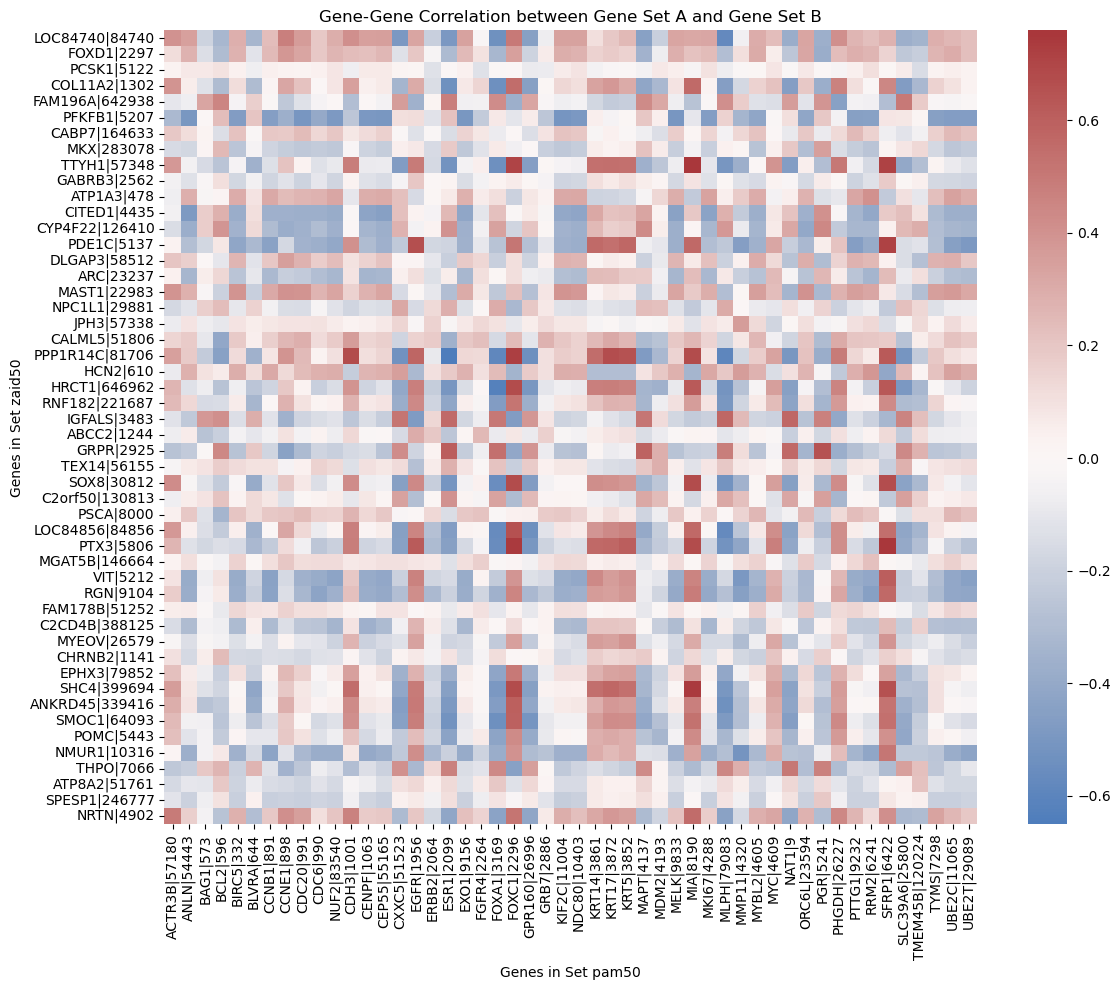

In [25]:
# X_A: individuals x 50 genes from set A
# X_B: individuals x 50 genes from set B

cross_corr = pd.DataFrame(np.corrcoef(X_zaid50.T, X_pam50.T)[:50, 50:], 
                          index=X_zaid50.columns, 
                          columns=X_pam50.columns)
plt.figure(figsize=(12, 10))
sns.heatmap(cross_corr, cmap='vlag', center=0, xticklabels=True, yticklabels=True)
plt.title("Gene-Gene Correlation between Gene Set A and Gene Set B")
plt.xlabel("Genes in Set pam50")
plt.ylabel("Genes in Set zaid50")
plt.tight_layout()
plt.show()

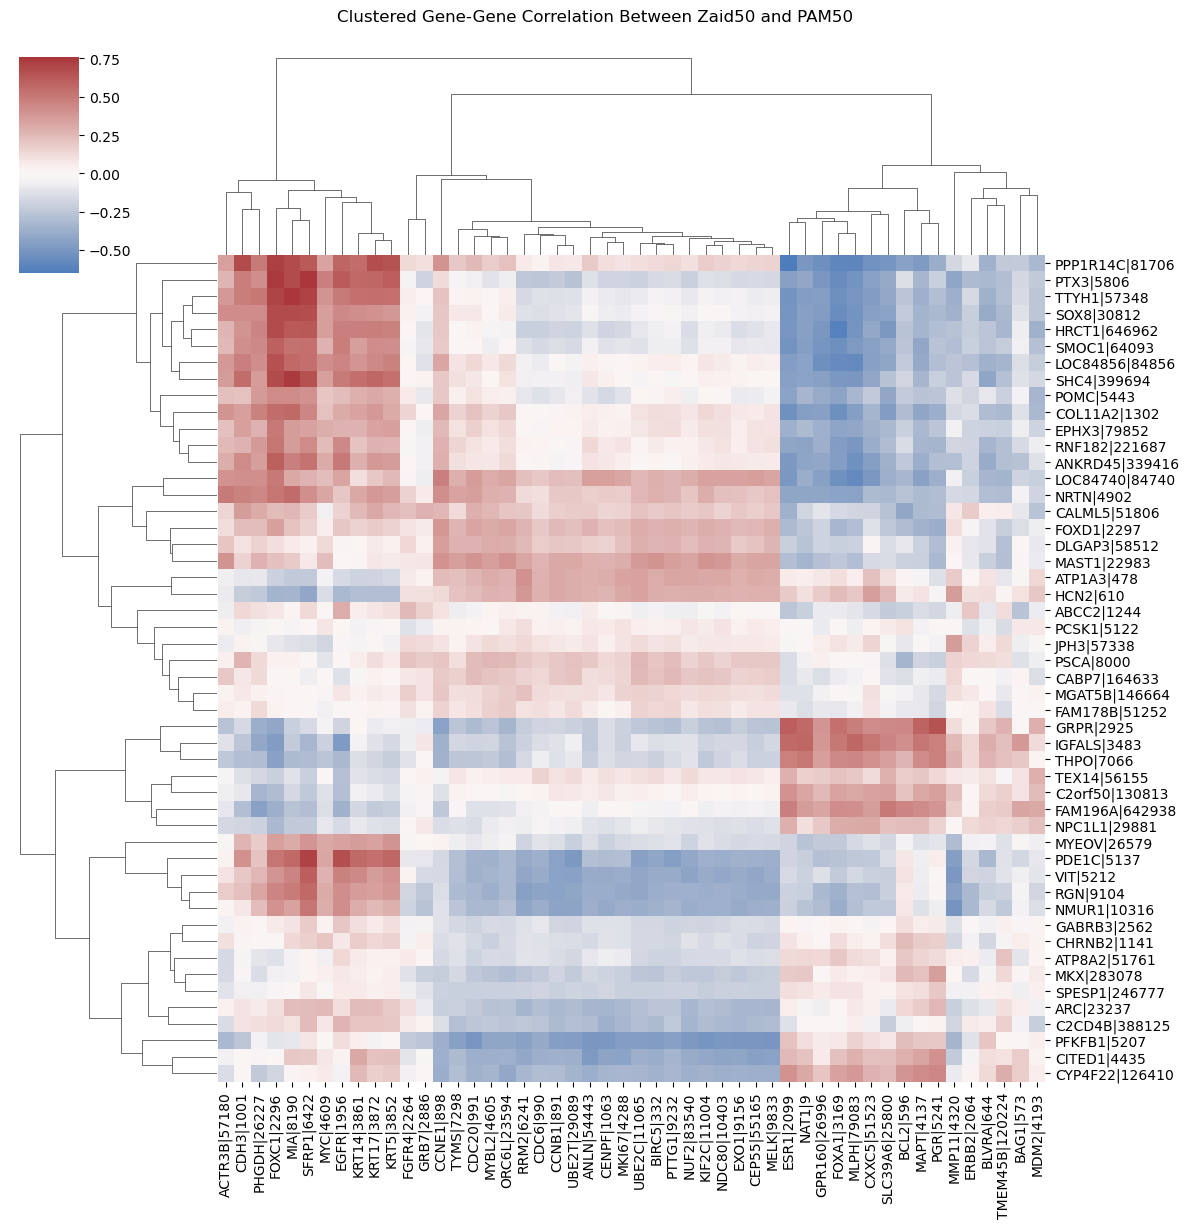

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clustered heatmap of gene-gene correlations
sns.clustermap(
    cross_corr,
    cmap="vlag",
    center=0,
    figsize=(12, 12),
    row_cluster=True,
    col_cluster=True,
    xticklabels=True,
    yticklabels=True
)

plt.suptitle("Clustered Gene-Gene Correlation Between Zaid50 and PAM50", y=1.02)
plt.show()


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

# Get average expression per individual
vec_A = X_zaid50_centered.mean(axis=1)
vec_B = X_pam50_centered.mean(axis=1)

# Compare their patterns across individuals
similarity = cosine_similarity(vec_A.values.reshape(1, -1), vec_B.values.reshape(1, -1))[0, 0]
print(f"Cosine similarity between gene set A and B profiles: {similarity:.4f}")


Cosine similarity between gene set A and B profiles: -0.0721


In [36]:
from sklearn.cross_decomposition import CCA

cca = CCA(n_components=1)
X_c, Y_c = cca.fit_transform(X_zaid50_centered, X_pam50_centered)
print(f"Canonical correlation: {np.corrcoef(X_c.T, Y_c.T)[0, 1]:.4f}")


Canonical correlation: 0.9720


In [37]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr

dist_A = squareform(pdist(X_zaid50_centered.T, metric='correlation'))
dist_B = squareform(pdist(X_pam50_centered.T, metric='correlation'))

# Flatten upper triangle
vec_A = dist_A[np.triu_indices_from(dist_A, k=1)]
vec_B = dist_B[np.triu_indices_from(dist_B, k=1)]

rv, _ = pearsonr(vec_A, vec_B)
print(f"RV-like correlation between gene set A and B: {rv:.4f}")


RV-like correlation between gene set A and B: -0.0424


In [39]:
from scipy.optimize import linear_sum_assignment

# Compute gene-gene cross-set correlation matrix
corr_matrix = np.corrcoef(X_zaid50_centered.T, X_pam50_centered.T)[:X_zaid50_centered.shape[1], X_zaid50_centered.shape[1]:]

# Convert to cost matrix (Hungarian algorithm minimizes cost)
# We want to *maximize* correlation → minimize (1 - corr)
cost_matrix = 1 - np.abs(corr_matrix)  # use abs if you care about strength, not sign

# Apply Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Extract optimal matches and their correlation values
matched_pairs = [(X_zaid50_centered.columns[i], X_pam50_centered.columns[j], corr_matrix[i, j])
                 for i, j in zip(row_ind, col_ind)]

# Optional: convert to DataFrame for easier viewing
matched_df = pd.DataFrame(matched_pairs, columns=['Gene_A', 'Gene_B', 'Correlation'])
matched_df = matched_df.sort_values('Correlation', ascending=False)

print(matched_df)


            Gene_A          Gene_B  Correlation
8      TTYH1|57348        MIA|8190     0.759707
20  PPP1R14C|81706       CDH3|1001     0.673951
28      SOX8|30812      SFRP1|6422     0.666823
13      PDE1C|5137       EGFR|1956     0.661201
31  LOC84856|84856      FOXC1|2296     0.659126
26       GRPR|2925        PGR|5241     0.653156
32       PTX3|5806       KRT5|3852     0.606633
41     SHC4|399694      KRT17|3872     0.570380
24     IGFALS|3483       MAPT|4137     0.510564
46       THPO|7066          NAT1|9     0.503027
49       NRTN|4902    ACTR3B|57180     0.491489
0   LOC84740|84740       CCNE1|898     0.473849
4   FAM196A|642938        BCL2|596     0.454506
10      ATP1A3|478       RRM2|6241     0.405576
16     MAST1|22983       BIRC5|332     0.391539
18      JPH3|57338      MMP11|4320     0.362736
38     MYEOV|26579      KRT14|3861     0.358081
1       FOXD1|2297       CDC20|991     0.327409
17    NPC1L1|29881     CXXC5|51523     0.317290
21        HCN2|610      MKI67|4288     0

In [40]:
X_A_scaled = X_zaid50_centered
X_B_scaled = X_pam50_centered

# Run CCA
cca = CCA(n_components=1)
X_c, Y_c = cca.fit_transform(X_A_scaled, X_B_scaled)


In [41]:
X_zaid50

,LOC84740|84740,FOXD1|2297,PCSK1|5122,COL11A2|1302,FAM196A|642938,PFKFB1|5207,CABP7|164633,MKX|283078,TTYH1|57348,GABRB3|2562,...,EPHX3|79852,SHC4|399694,ANKRD45|339416,SMOC1|64093,POMC|5443,NMUR1|10316,THPO|7066,ATP8A2|51761,SPESP1|246777,NRTN|4902
0,2.546586,0.756426,17.084476,2.260387,6.190490,3.158208,3.199924,1.617298,4.343472,1.909696,...,1.909696,2.454334,1.250113,8.281666,1.770871,2.625247,6.217469,6.762003,2.360617,3.212849
1,1.901185,7.575743,2.559247,4.158418,2.803537,3.755614,5.134964,2.091734,4.844612,8.444895,...,3.194812,2.803537,2.419593,3.569916,3.502292,2.559247,5.718595,1.894876,1.666802,4.731042
2,3.335340,7.741838,4.950394,5.905211,1.492212,4.508353,2.302962,2.468088,4.449707,1.492212,...,2.686993,2.877018,0.931002,2.468088,4.992089,3.044901,5.883220,2.686993,3.570390,1.492212
3,2.583471,3.276273,3.147470,3.789291,4.843999,2.849199,2.198871,10.826922,3.276273,4.166972,...,2.849199,5.362203,0.869871,6.543234,5.287757,2.763900,2.673240,5.056211,2.929753,4.231939
4,2.718745,2.798548,2.393773,6.309211,5.553281,1.645102,1.913033,9.546524,5.199464,4.752609,...,3.312694,6.576947,1.829119,1.829119,3.114300,2.138913,5.059200,5.264792,2.256618,4.270372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,1.783876,1.783876,2.909965,5.709109,6.246670,3.969104,4.338446,2.909965,4.758298,2.744484,...,3.810649,2.744484,0.859572,3.969104,2.090176,2.909965,5.234670,3.429482,3.316073,0.000000
1128,3.641130,2.943528,6.459561,3.923453,6.766516,5.556521,2.132840,4.370513,4.913315,4.476369,...,3.539767,3.765365,2.613084,5.927008,3.885526,4.065917,5.349217,3.272232,7.006242,2.303635
1129,7.112773,3.679108,4.244118,4.131985,3.174758,5.700872,2.934743,5.110113,4.897937,8.308398,...,3.248322,4.010395,1.530820,4.207705,3.731346,5.168125,4.476155,2.106549,6.385804,3.097257
1130,1.484344,3.479541,4.671859,4.047041,3.821812,2.373286,3.273083,3.759550,7.042349,6.808655,...,3.938813,8.353747,3.226894,6.433235,4.769878,2.801821,5.866475,4.453261,1.133958,4.602611


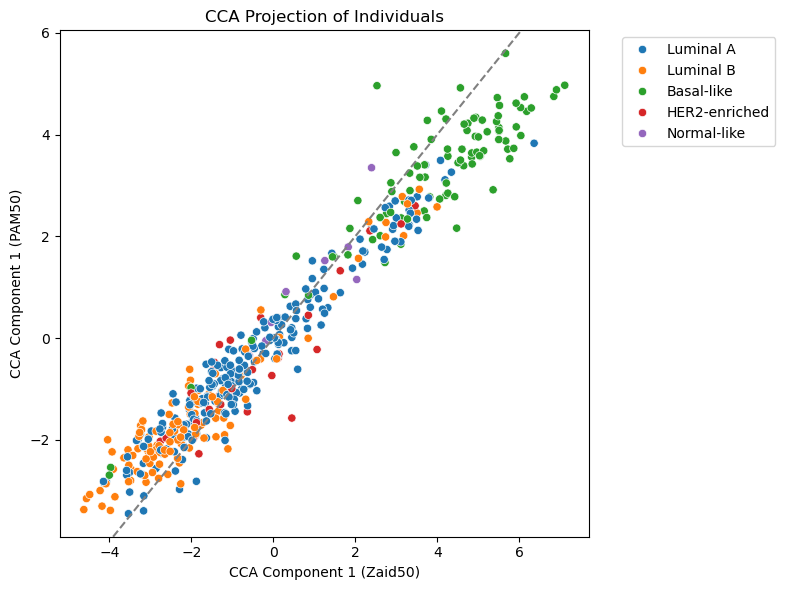

In [47]:
# Optional: include labels (e.g., PAM50 subtype)
labels = pam50_labels  # e.g., Series with "Luminal A", "Basal-like", etc.

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_c[:, 0], y=Y_c[:, 0], hue=labels, palette='tab10')
plt.xlabel("CCA Component 1 (Zaid50)")
plt.ylabel("CCA Component 1 (PAM50)")
plt.title("CCA Projection of Individuals")
plt.axline((0, 0), slope=1, color='gray', linestyle='--')  # Identity line
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


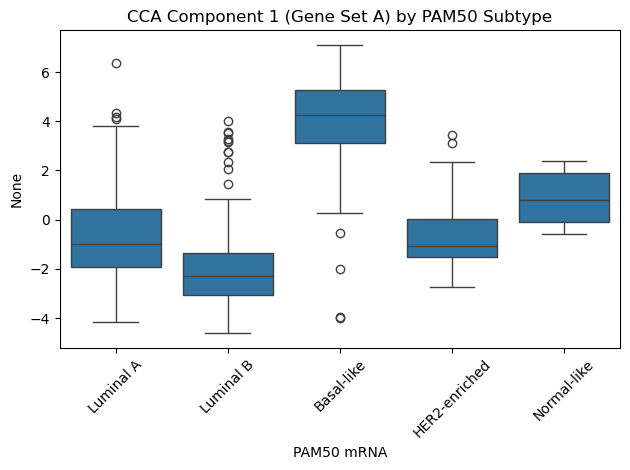

In [45]:
# CCA latent variable from gene set A
cca_latent = pd.Series(X_c[:, 0], index=X_zaid50.index)

# Compare across groups
sns.boxplot(x=pam50_labels, y=cca_latent)
plt.title("CCA Component 1 (Gene Set A) by PAM50 Subtype")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [50]:
# Coefficients for each gene in the CCA projection
coef_A = pd.Series(cca.x_weights_[:, 0], index=X_zaid50.columns).sort_values(key=np.abs, ascending=False)
coef_B = pd.Series(cca.y_weights_[:, 0], index=X_pam50.columns).sort_values(key=np.abs, ascending=False)

print("Top contributing genes from Zaid50:")
print(coef_A.head())

print("\nTop contributing genes from PAM50:")
print(coef_B.head())

Top contributing genes from Zaid50:
PPP1R14C|81706    0.558263
PTX3|5806         0.368540
SHC4|399694       0.265352
LOC84740|84740    0.224083
HRCT1|646962      0.217899
dtype: float64

Top contributing genes from PAM50:
MIA|8190       0.439528
FOXC1|2296     0.396396
UBE2C|11065   -0.356588
FOXA1|3169    -0.262227
SFRP1|6422     0.244300
dtype: float64
